# Loan Approval Prediction

#### **Problem Statement**
The manual loan approval process used by financial institutions is often time-consuming, inconsistent, and prone to human error. This can lead to a significant number of qualified applicants being rejected or, conversely, risky applicants being approved. The challenge is to build a reliable system that can automate and optimize this decision-making process.

#### **Goal**
The primary goal is to develop a robust and accurate machine learning model that can predict the likelihood of a loan being approved based on an applicant's features. The model must not only perform well on the data it was trained on but also generalize effectively to new, unseen loan applications.

### Project Overview

#### **The Initial Approach: Tackling Complexity**
My first step was to prepare the data through a rigorous preprocessing pipeline. I addressed **missing values** and **inconsistent data**, engineered powerful new features like **TotalIncome** and **Loan_to_Income_Ratio**, and handled **skewed data distributions**. To ensure a robust workflow, I built a pipeline for **Standard Scaling** and **One-Hot Encoding** to prevent data leakage.

Only after this comprehensive preparation, I addressed the primary challenge of **class imbalance using SMOTE (Synthetic Minority Over-sampling Technique)** to generate synthetic data points for the minority class. I then trained powerful, complex models like **Random Forest** and **XGBoost**. The initial results showed severe **overfitting**; the models performed nearly perfectly on the training data but failed to generalize to the unseen test set.

Even after performing extensive hyperparameter tuning, the overfitting persisted. The best-tuned XGBoost model achieved a test **F1-Score of 0.8521**, which was good but still showed a significant gap from its training performance. This taught me that more complex models are not always the answer, especially with a dataset of this size.

#### **A Critical Discovery: Correcting the Workflow**
While working on the project, I realized a fundamental error in my previous data science workflows: I was performing preprocessing steps like missing value imputation and feature engineering **before** splitting the data. This caused **data leakage**, biasing the model's evaluation and leading to deceptively good results.

I corrected my entire process, ensuring the data was **split first**. All subsequent steps—imputation, feature engineering, and scaling—were then performed independently on the training and test sets. This ensured that the model's final performance was an accurate reflection of its ability to generalize.

#### **The Final Breakthrough: Simplicity and Optimization**
As a final test, I trained a simpler Logistic Regression model. The results were surprising: the model not only avoided overfitting but also achieved a higher test **F1-Score of 0.8706** than the complex, tuned models. This demonstrated that a linear, less-complex model was a better fit for the data's underlying patterns.

To complete the project, I decided to perform hyperparameter tuning on the already-winning Logistic Regression model. This optimization was a major success, boosting the model's test **F1-Score to 0.9032** and making it the definitive best model for the project.

This entire process highlights a critical lesson: the best model isn't the most complex one, but the one with the **optimal complexity** for the problem. My final Logistic Regression model perfectly balanced simplicity and performance to achieve a robust, high-performing result.

## 1. Loading Packages and Data

In [1]:
from scipy.stats import uniform, loguniform
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import NearestNeighbors
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, precision_recall_curve
import joblib

In [2]:
# For reproducibility
import random
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
df_original = pd.read_csv("D:/Downloads/Dataset/Dataset/train_ctrUa4K.csv")
df = df_original.copy() # Work on a copy
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


## 2. Understanding Data & Initial EDA

In [3]:
print("\n--- dataset information ---")
df.info()


--- dataset information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [4]:
print("\n--- Descriptive Statistics (Numerical) ---")
df.describe()  # training data


--- Descriptive Statistics (Numerical) ---


,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [5]:
print("\n--- Descriptive Statistics (Categorical) ---")
df.describe(include="object")


--- Descriptive Statistics (Categorical) ---


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
count,614,601,611,599,614,582,614,614
unique,614,2,2,4,2,2,3,2
top,LP002990,Male,Yes,0,Graduate,No,Semiurban,Y
freq,1,489,398,345,480,500,233,422


In [6]:
print("\n--- Value Counts for Categorical Features (Initial) in training data ---")
categorical_cols_initial = ["Gender","Married","Dependents","Education","Self_Employed","Loan_Amount_Term","Credit_History",
                            "Property_Area", "Loan_Status"]
for colm in categorical_cols_initial:
    if colm in df.columns:
        print(f"\nValue counts for {colm}:")
        print(df[colm].value_counts(dropna=False))  # Show NaNs in value_counts
        print("=="*20)


--- Value Counts for Categorical Features (Initial) in training data ---

Value counts for Gender:
Gender
Male      489
Female    112
NaN        13
Name: count, dtype: int64

Value counts for Married:
Married
Yes    398
No     213
NaN      3
Name: count, dtype: int64

Value counts for Dependents:
Dependents
0      345
1      102
2      101
3+      51
NaN     15
Name: count, dtype: int64

Value counts for Education:
Education
Graduate        480
Not Graduate    134
Name: count, dtype: int64

Value counts for Self_Employed:
Self_Employed
No     500
Yes     82
NaN     32
Name: count, dtype: int64

Value counts for Loan_Amount_Term:
Loan_Amount_Term
360.0    512
180.0     44
480.0     15
NaN       14
300.0     13
84.0       4
240.0      4
120.0      3
60.0       2
36.0       2
12.0       1
Name: count, dtype: int64

Value counts for Credit_History:
Credit_History
1.0    475
0.0     89
NaN     50
Name: count, dtype: int64

Value counts for Property_Area:
Property_Area
Semiurban    233
Urba


--- Target Variable Distribution ---
Loan_Status
Y    0.687296
N    0.312704
Name: proportion, dtype: float64


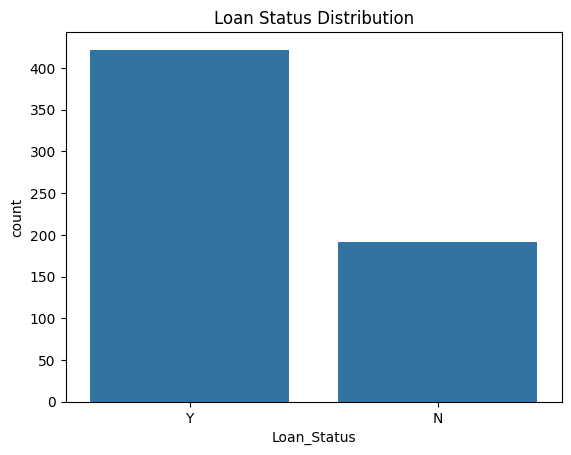

In [7]:
print("\n--- Target Variable Distribution ---")
print(df['Loan_Status'].value_counts(normalize=True))
sns.countplot(data=df, x='Loan_Status')
plt.title('Loan Status Distribution')
plt.show()

Looking at the proportion of the values of `Loan_Status`, it can be said that the dataset is imbalanced.


--- Distribution of unprocessed numerical data in training data ---


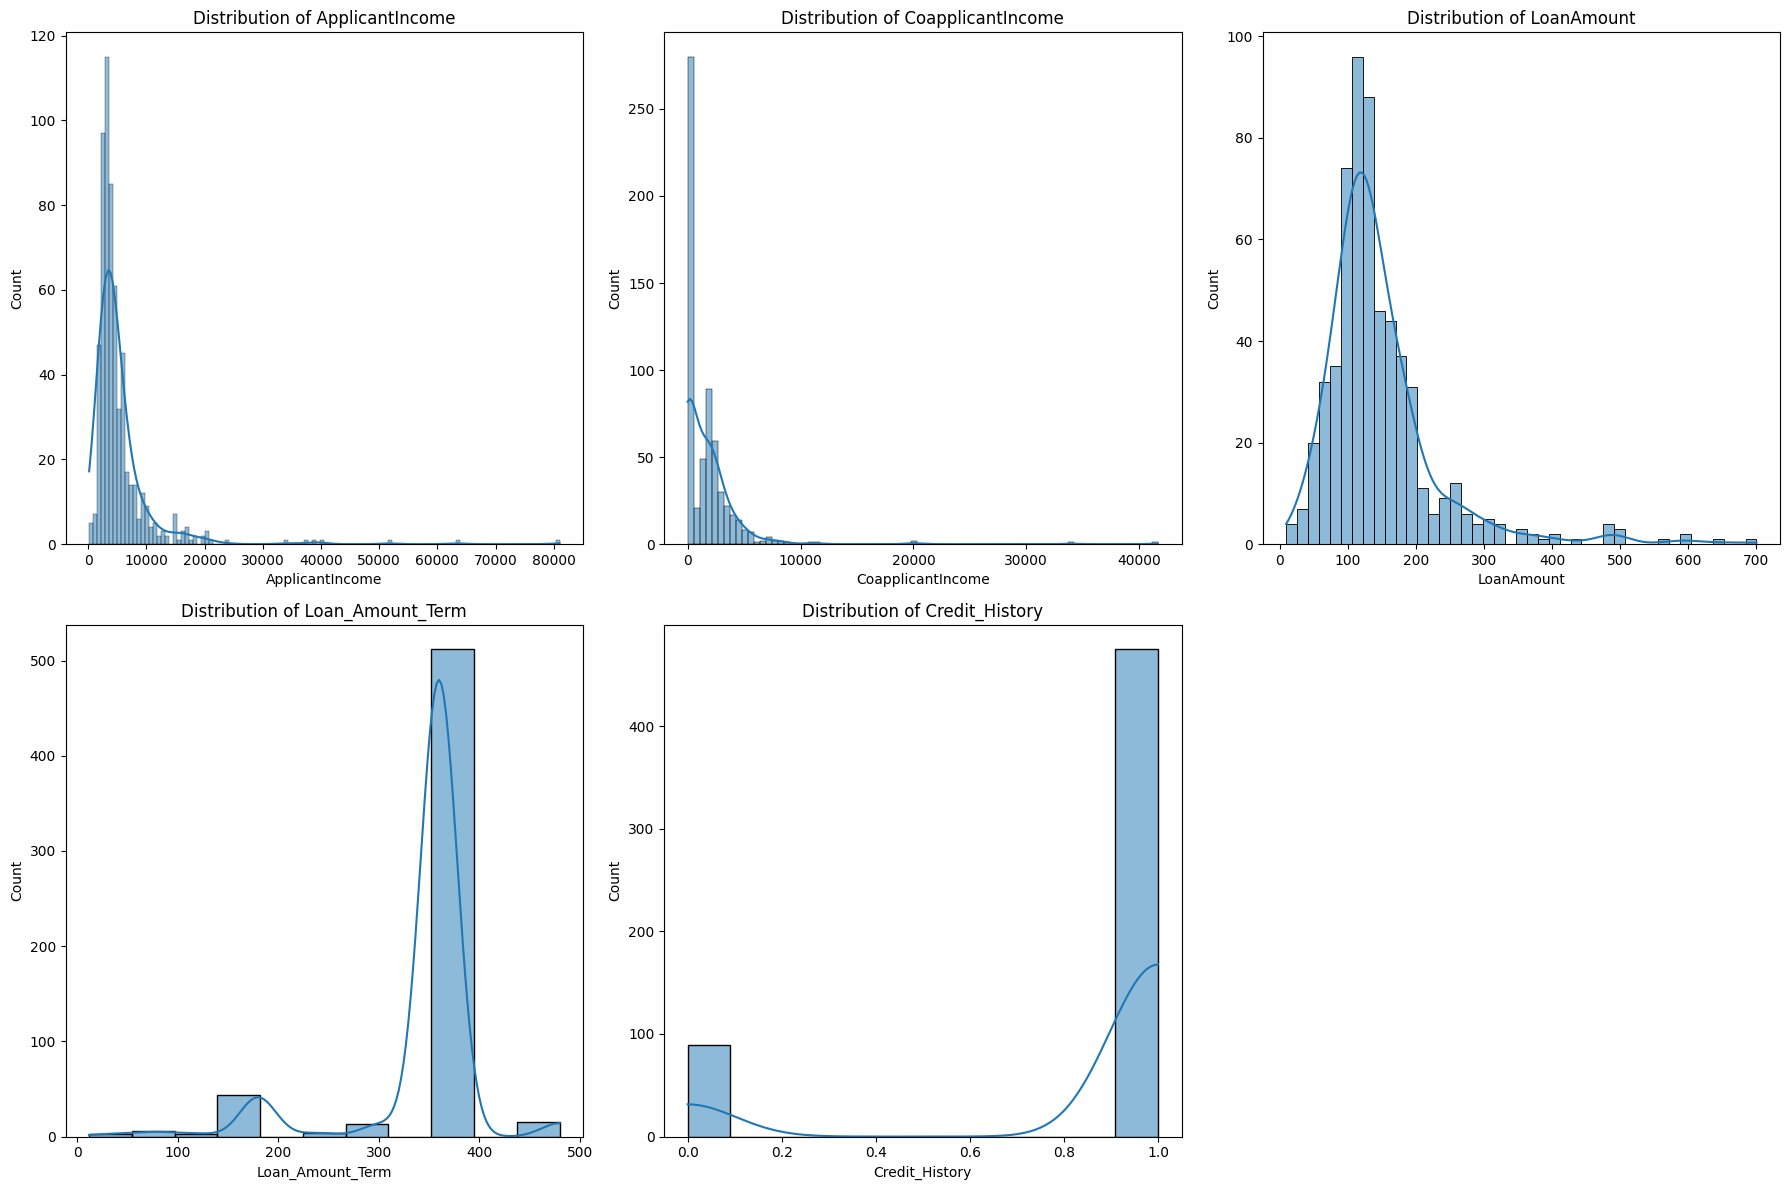

In [8]:
numerical_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
print('\n--- Distribution of unprocessed numerical data in training data ---')
plt.figure(figsize=(18, 12))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 3, i + 1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

- **ApplicantIncome & CoapplicantIncome:** These are a highly right-skewed distribution in both training and data. Most applicants and coapplicants have lower incomes, with a very dense concentration around the lower end of the income scale. There's a long tail extending to the right, indicating a few applicants with very high incomes. Highly skewed data like this might need transformation (e.g., log transformation) to improve model performance and prevent the model from being disproportionately influenced by the high-income outliers.


- **LoanAmount:** This distribution is moderately right-skewed, but less severely than the income variables. It has a more pronounced central peak, indicating a common range for loan amounts, with a tail extending towards higher loan amounts.


- **Loan_Amount_Term:** This is a multi-modal distribution with distinct peaks, most notably around 120 and 360. There are smaller peaks at other terms as well. This variable is likely categorical (even if stored numerically), representing standard loan term options. It should probably be treated as such in a model, or one-hot encoded. The distinct modes confirm it's not a continuous spectrum.


- **Credit_History:** This variable is binary (0 or 1). One value represents the presence of a favorable credit history (e.g., 1 = "Credit History Met" or "Good Credit") and the other represents the absence or a negative credit history (e.g., 0 = "No Credit History" or "Bad Credit").

## 3. Data Cleaning & Preprocessing

### 3.1. Train-Test split

In [9]:
# splitting the data before missing values imputation, feature engineering, feature encoding and feature scaling to avoid data leakage
X = df.drop('Loan_Status', axis=1)
y = df['Loan_Status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y) # Added stratify
print(f"\nShapes: X_train: {X_train.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}")


Shapes: X_train: (491, 12), X_test: (123, 12), y_train: (491,), y_test: (123,)


### 3.1. Treating Missing Values

In [10]:
print("\n--- Missing Values Before Imputation in training data ---")
print(X_train.isnull().sum())
print("\n--- Missing Values Before Imputation in testing data ---")
print(X_test.isnull().sum())


--- Missing Values Before Imputation in training data ---
Loan_ID               0
Gender               11
Married               3
Dependents            8
Education             0
Self_Employed        27
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           20
Loan_Amount_Term     12
Credit_History       43
Property_Area         0
dtype: int64

--- Missing Values Before Imputation in testing data ---
Loan_ID              0
Gender               2
Married              0
Dependents           7
Education            0
Self_Employed        5
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           2
Loan_Amount_Term     2
Credit_History       7
Property_Area        0
dtype: int64


In [11]:
# Impute categorical features with mode in training and testing data
for col in ['Gender', 'Married', 'Dependents', 'Self_Employed', 'Loan_Amount_Term', 'Credit_History']:
    mode_val = X_train[col].mode()[0]
    X_train.fillna({col:mode_val}, inplace=True)
    X_test.fillna({col:mode_val}, inplace=True)
    print(f"Filled NaNs in {col} with mode: {mode_val}")

Filled NaNs in Gender with mode: Male
Filled NaNs in Married with mode: Yes
Filled NaNs in Dependents with mode: 0
Filled NaNs in Self_Employed with mode: No
Filled NaNs in Loan_Amount_Term with mode: 360.0
Filled NaNs in Credit_History with mode: 1.0


In [12]:
# Impute LoanAmount with median (more robust to outliers than mean)
median_loan_amount = X_train['LoanAmount'].median()
X_train.fillna({'LoanAmount':median_loan_amount}, inplace=True)
X_test.fillna({'LoanAmount':median_loan_amount}, inplace=True)
print(f"Filled NaNs in LoanAmount with median: {median_loan_amount}")

Filled NaNs in LoanAmount with median: 128.0


In [13]:
print("\n--- Missing Values After Imputation in training data ---")
print(X_train.isnull().sum())
print("\n--- Missing Values After Imputation in testing data ---")
print(X_test.isnull().sum())


--- Missing Values After Imputation in training data ---
Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
dtype: int64

--- Missing Values After Imputation in testing data ---
Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
dtype: int64


### 3.3. Feature Engineering

#### **New Features**

- **TotalIncome:** We're creating this feature to capture the **combined financial capacity** of the applicant and co-applicant.  While individual incomes are important, the total household income is a more holistic and realistic measure of the overall ability to repay the loan. A model might not independently deduce this relationship from the two separate income features.

- **Loan_to_Income_Ratio:** This feature provides a crucial measure of the **debt burden** relative to the income. It's a key metric used in real-world credit analysis. By explicitly calculating this ratio, we are giving the model a direct, powerful signal about the level of financial stress the loan might impose on the borrower. This makes it easier for the model to identify high-risk applicants, as a high ratio often correlates with a higher likelihood of default.

In [14]:
# TotalIncome
X_train['TotalIncome'] = X_train[['ApplicantIncome', 'CoapplicantIncome']].sum(axis=1) # training set
X_test['TotalIncome'] = X_test[['ApplicantIncome', 'CoapplicantIncome']].sum(axis=1) # testing set

In [15]:
# Loan to Income Ratio - Handle potential division by zero if TotalIncome can be 0
# training set
X_train['Loan_to_Income_Ratio'] = X_train['LoanAmount'] / (X_train['TotalIncome'].replace(0, np.nan))
X_train.fillna({'Loan_to_Income_Ratio':X_train['Loan_to_Income_Ratio'].median()}, inplace=True)

# testing set
X_test['Loan_to_Income_Ratio'] = X_test['LoanAmount'] / (X_test['TotalIncome'].replace(0, np.nan))
X_test.fillna({'Loan_to_Income_Ratio':X_test['Loan_to_Income_Ratio'].median()}, inplace=True)

### 3.3. Log Transformation for Skewed Numerical Features

In [16]:
# ApplicantIncome, CoapplicantIncome, LoanAmount, TotalIncome are positively skewed
numerical_skewed = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'TotalIncome', 'Loan_to_Income_Ratio']
print("\n--- Applying Log Transformation to Skewed Numerical Features in training data ---")
for col in numerical_skewed:
    X_train[col] = np.log1p(X_train[col]) # log1p handles 0 values better (log(1+x))
    print(f"Applied log1p transformation to {col}")

print("\n--- Applying Log Transformation to Skewed Numerical Features in testing data ---")
for col in numerical_skewed:
    X_test[col] = np.log1p(X_test[col]) # log1p handles 0 values better (log(1+x))
    print(f"Applied log1p transformation to {col}")


--- Applying Log Transformation to Skewed Numerical Features in training data ---
Applied log1p transformation to ApplicantIncome
Applied log1p transformation to CoapplicantIncome
Applied log1p transformation to LoanAmount
Applied log1p transformation to TotalIncome
Applied log1p transformation to Loan_to_Income_Ratio

--- Applying Log Transformation to Skewed Numerical Features in testing data ---
Applied log1p transformation to ApplicantIncome
Applied log1p transformation to CoapplicantIncome
Applied log1p transformation to LoanAmount
Applied log1p transformation to TotalIncome
Applied log1p transformation to Loan_to_Income_Ratio


## 4. Further EDA on Processed Training Data

### 4.1. Univariate Analysis (Visualizations for Numerical Features after Transformation) 


--- Distribution of features in training data ---


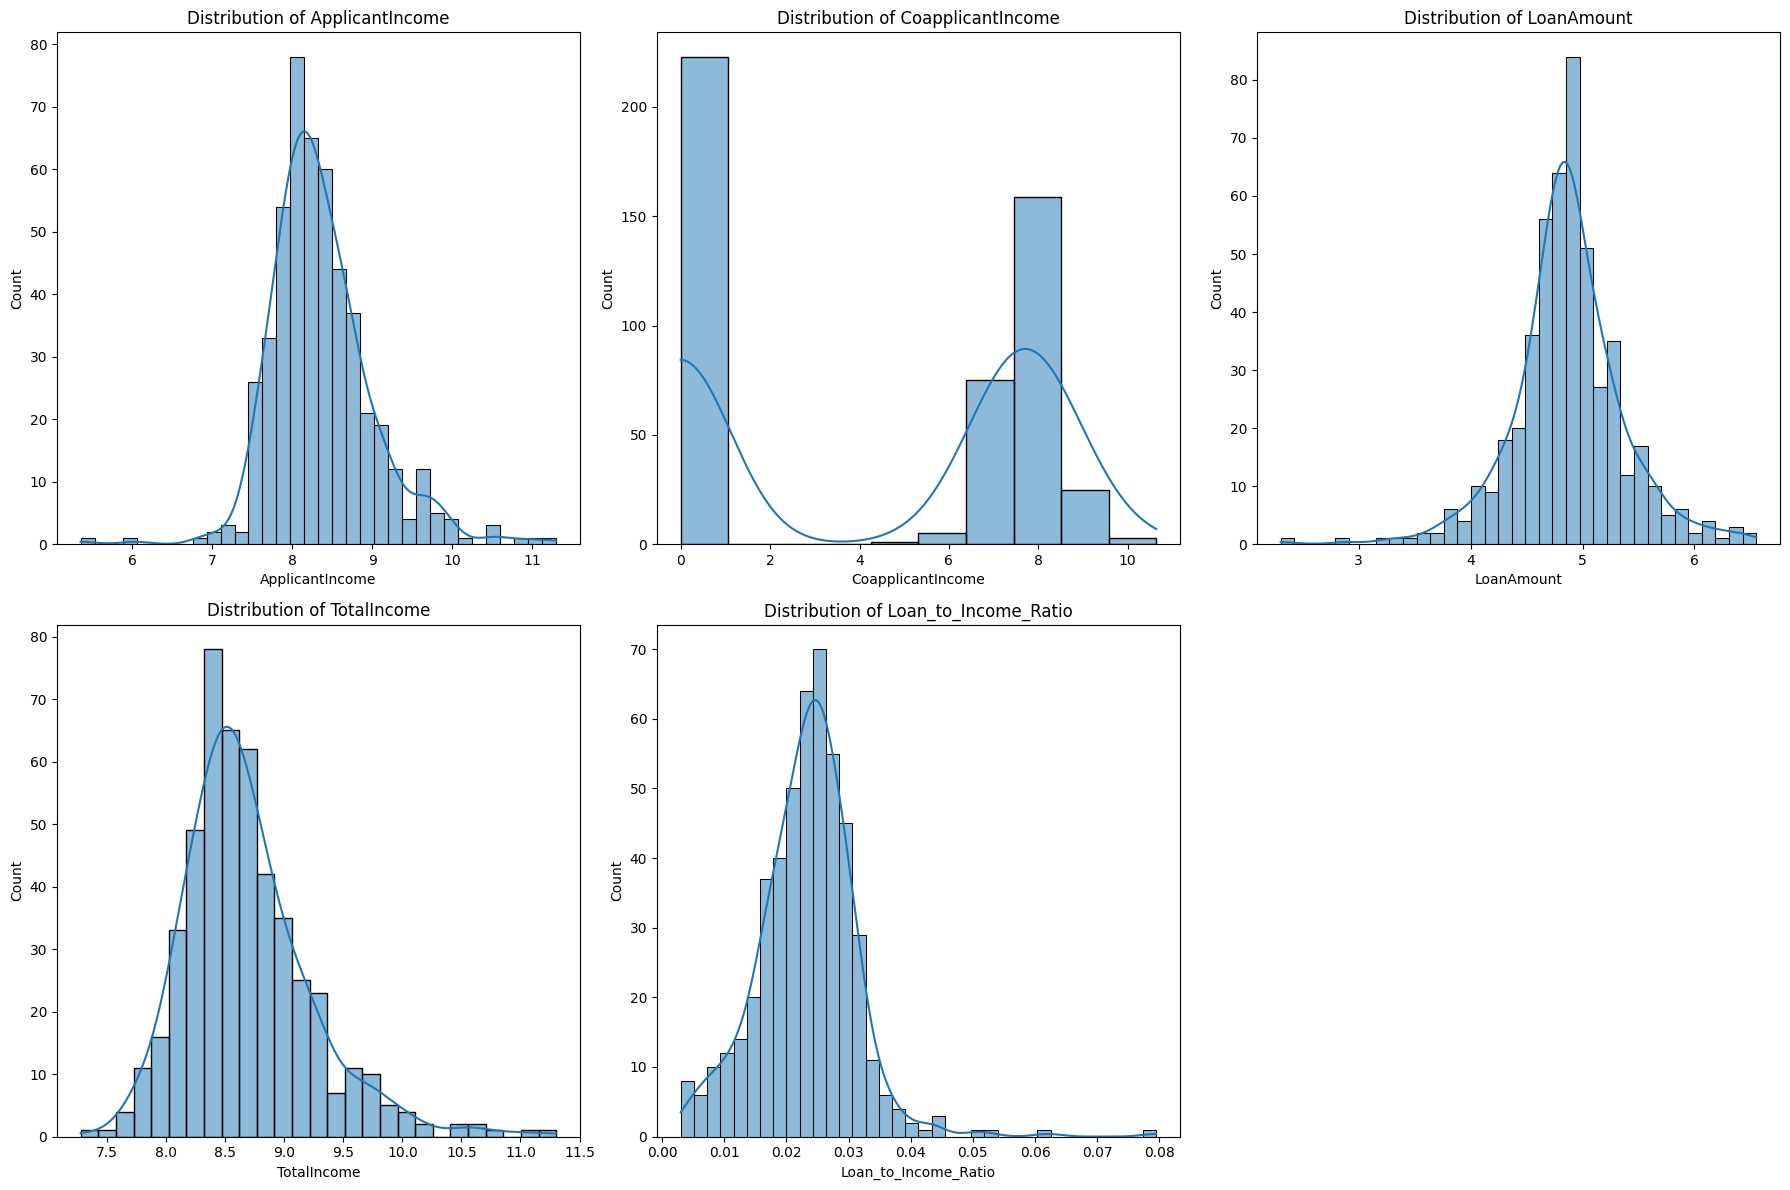

In [17]:
numerical_cols_processed = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'TotalIncome', 'Loan_to_Income_Ratio']
print('\n--- Distribution of features in training data ---')
plt.figure(figsize=(18, 12))
for i, col in enumerate(numerical_cols_processed):
    plt.subplot(2, 3, i + 1)
    sns.histplot(X_train[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

1. **Distribution of ApplicantIncome (Log Transformed):**
This plot looks great. The distribution is much more symmetrical and bell-shaped compared to the original, un-transformed data. This transformation has successfully handled the right skewness and reduced the impact of outliers.

2. **Distribution of CoapplicantIncome (Log Transformed):**
This plot shows a bimodal distribution with two distinct peaks.

    - The first peak is at the very beginning (around 0), which represents all the loan applications with zero co-applicant income. This is a very common scenario for single applicants.

    - The second peak is around the 7-8 mark. This represents the applicants who do have a co-applicant income.
    This bimodal shape is expected and perfectly normal for this type of data. It provides valuable information to the model about whether an applicant is single or has a partner contributing to the income.

3. **Distribution of LoanAmount (Log Transformed):**
Similar to `ApplicantIncome`, this plot is also much closer to a normal distribution. The log transformation has done an excellent job of making the data more symmetrical and reducing the effect of extreme loan values.

4. **Distribution of TotalIncome (Log Transformed):**
This plot is a combination of the `ApplicantIncome` and `CoapplicantIncome` distributions. It looks very similar to the `ApplicantIncome` plot, showing a nice bell-shaped curve. The log transformation was very effective at normalizing this new feature, which is a key step in ensuring its quality for the model.

5. **Distribution of Loan_to_Income_Ratio (Log Transformed):** The histogram shows that the distribution of `Loan_to_Income_Ratio` is **right-skewed**, which is a normal and expected characteristic for a ratio like this.

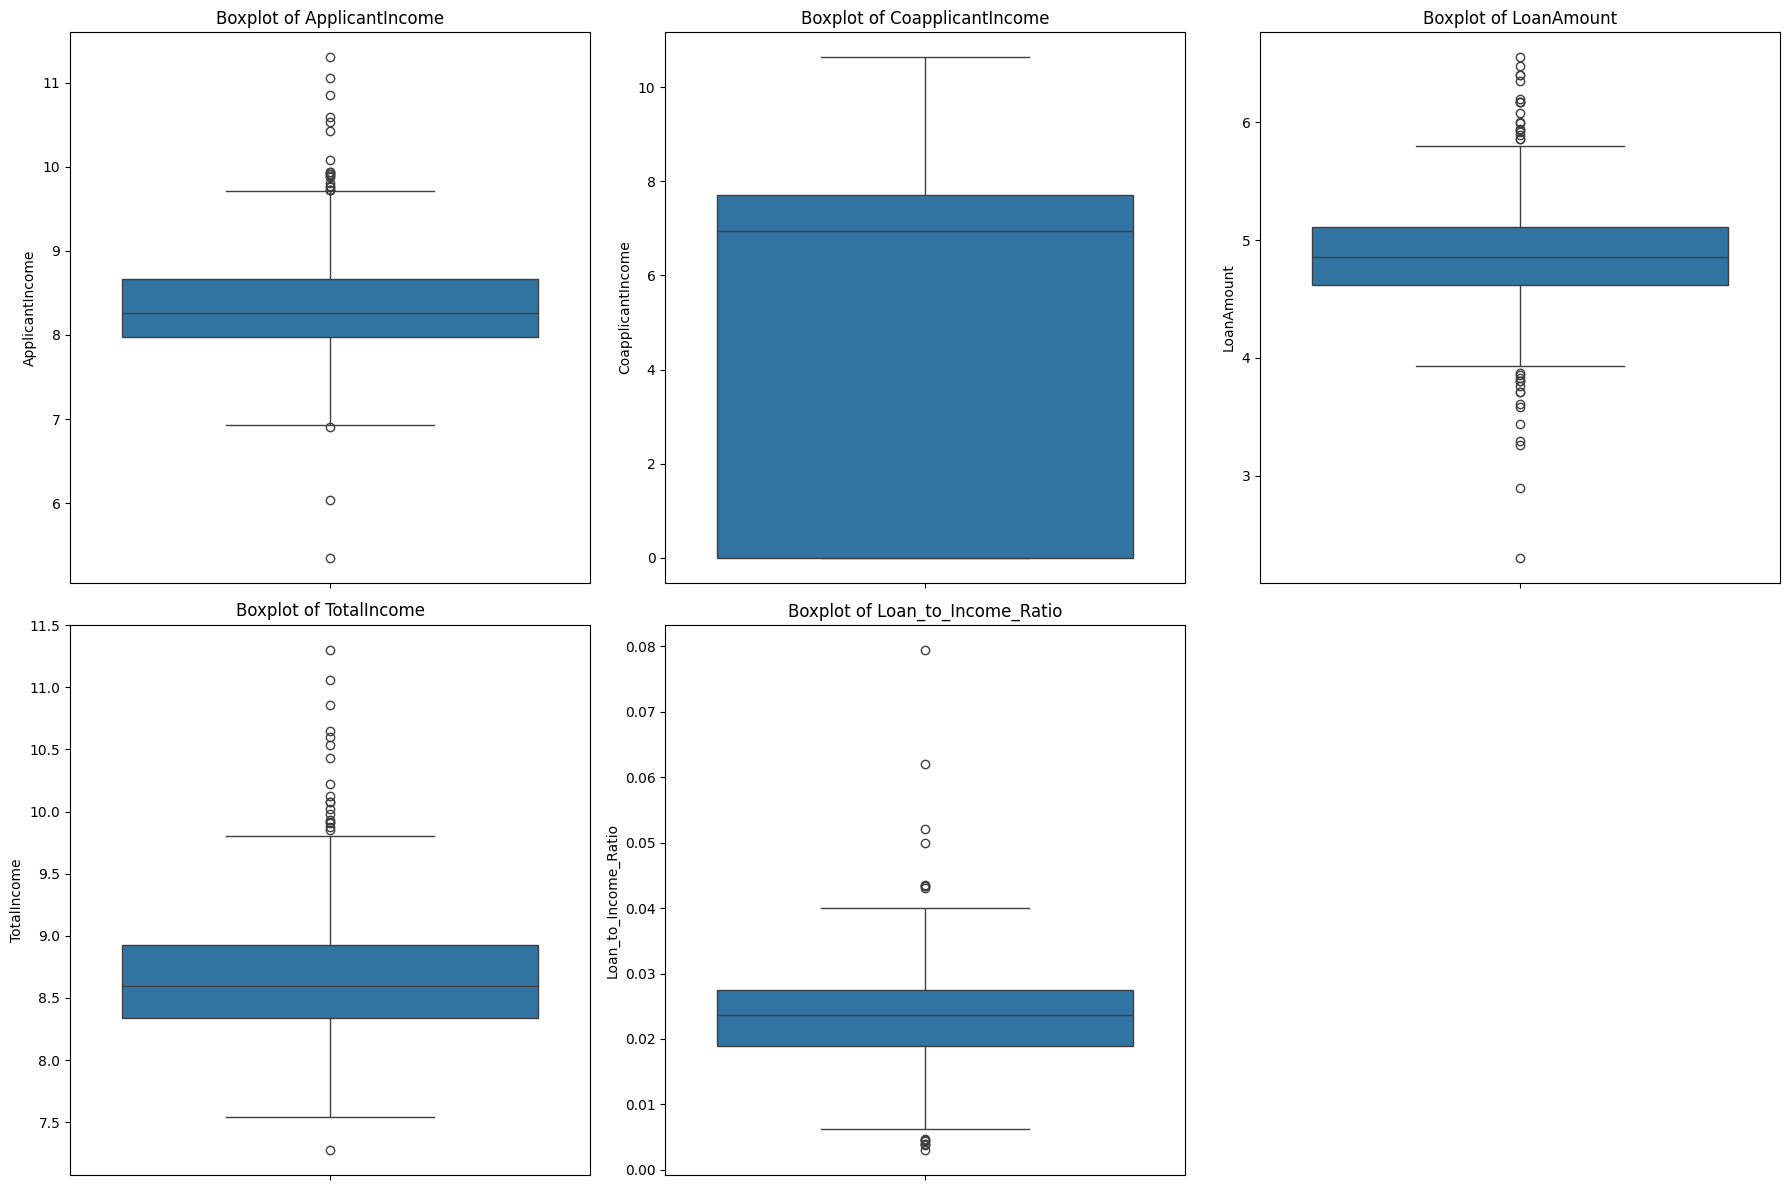

In [18]:
plt.figure(figsize=(18, 12))
for i, col in enumerate(numerical_cols_processed):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(y=X_train[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

### 4.2. Bivariate Analysis (Feature vs. Target)

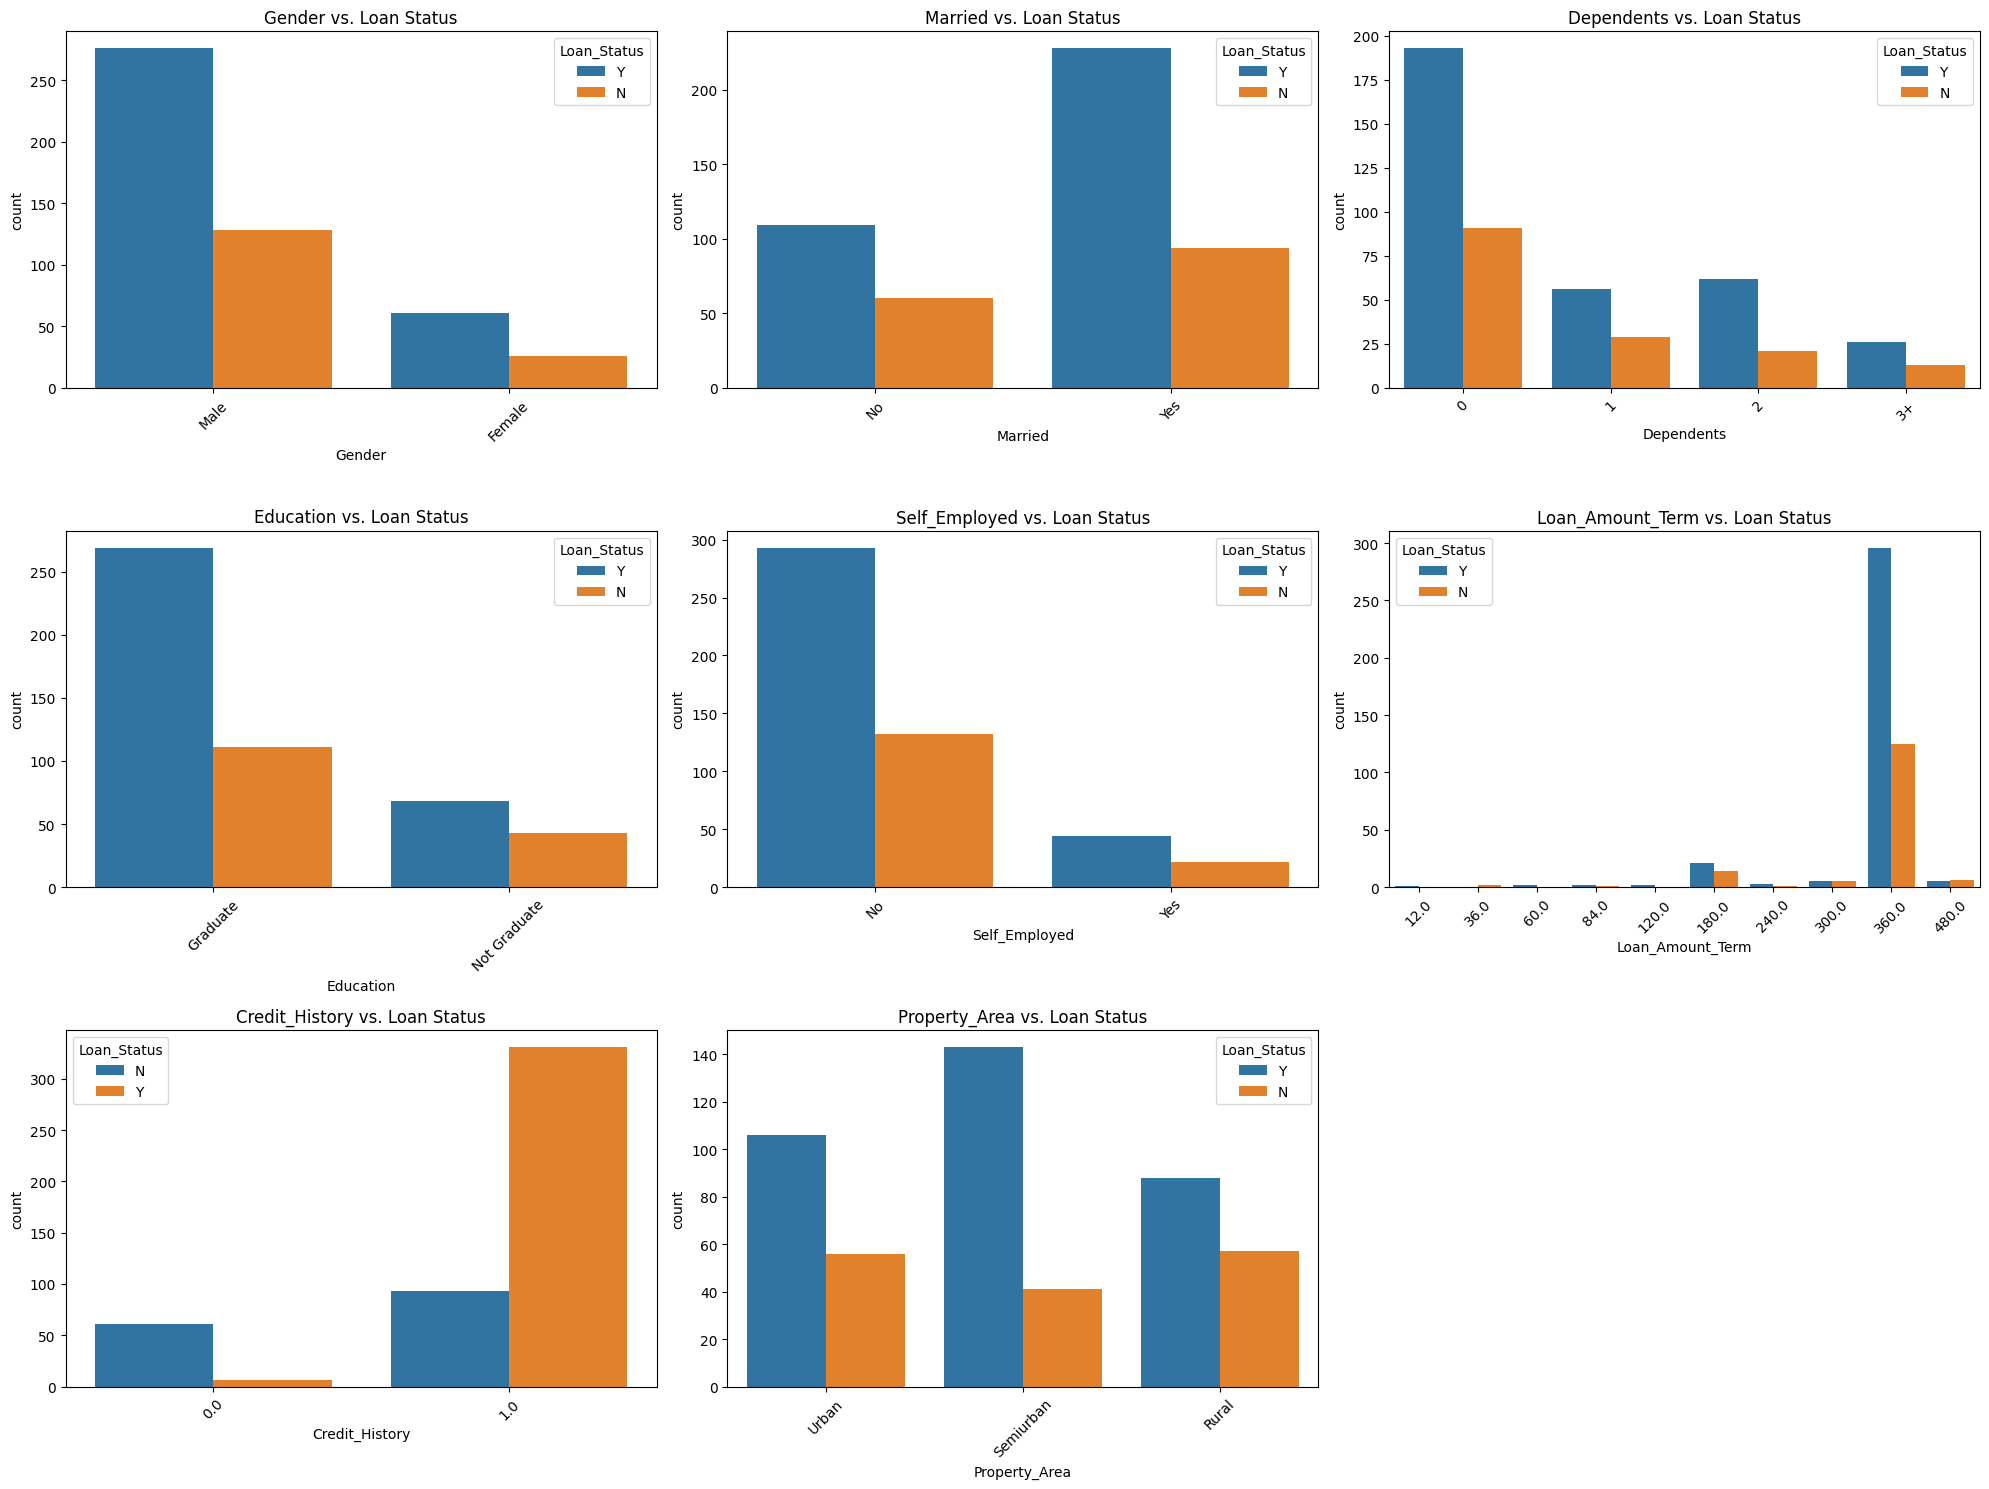

In [19]:
categorical_cols_for_bivariate = ["Gender","Married","Dependents","Education","Self_Employed","Loan_Amount_Term",
                                  "Credit_History","Property_Area"]

plt.figure(figsize=(20, 15))
for i, col in enumerate(categorical_cols_for_bivariate):
    plt.subplot(3, 3, i + 1)
    sns.countplot(x=X_train[col], hue=y_train)
    plt.title(f'{col} vs. Loan Status')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

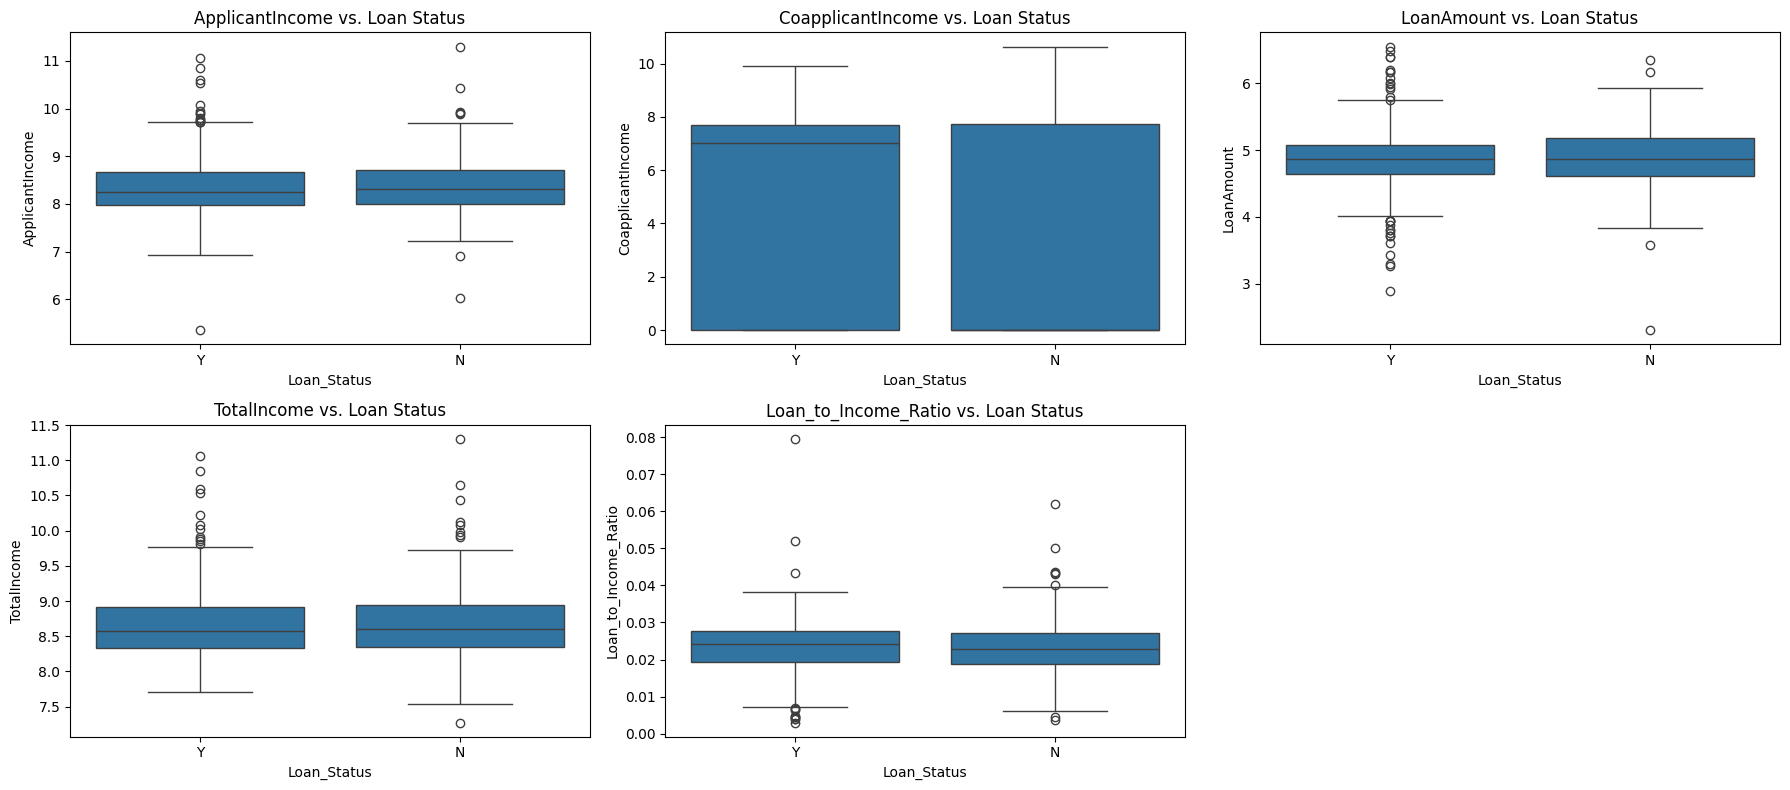

In [20]:
# Numerical vs. Target
plt.figure(figsize=(18, 8))
for i, col in enumerate(numerical_cols_processed):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(x=y_train, y=X_train[col])
    plt.title(f'{col} vs. Loan Status')
plt.tight_layout()
plt.show()

### 4.3. Correlation Heatmap (for numerical features)

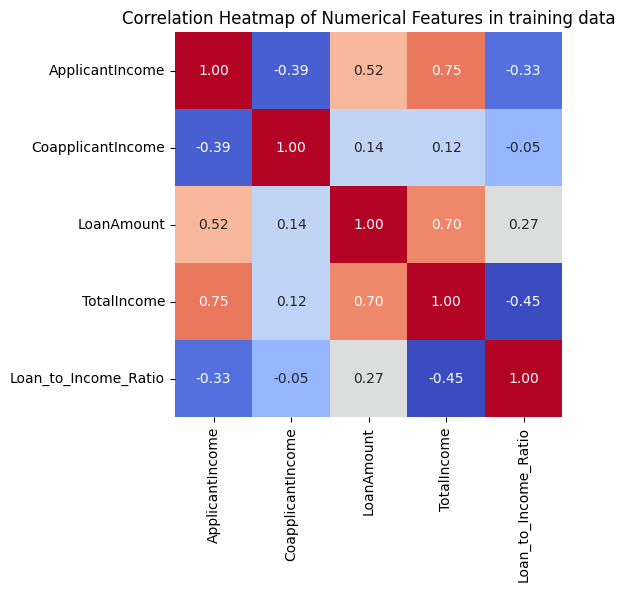

In [21]:
plt.figure(figsize=(5, 5))
sns.heatmap(X_train[numerical_cols_processed].corr(), annot=True, cmap='coolwarm', fmt=".2f", cbar=False)
plt.title('Correlation Heatmap of Numerical Features in training data')
plt.show()

- The correlation (+ve corr.) between `ApplicantIncome` and `TotalIncome` is very high (`0.75`), This is because we have created `TotalIncome` by summing up `ApplicantIncome` and `CoapplicantIncome`.


- The Correlation between (+ve corr.) `LoanAmount` and `TotalIncome` is also very high (`0.70`).


- There is also moderately -ve correlation between `TotalIncome` and `Loan_to_Income_Ratio`.

## 5. Feature Scaling and Encoding

In [22]:
# Drop Loan_ID as it's an identifier
X_train.drop('Loan_ID', axis=1, inplace=True)
X_test.drop('Loan_ID', axis=1, inplace=True)
X_train.head()  #training data

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,TotalIncome,Loan_to_Income_Ratio
154,Male,No,0,Graduate,No,8.087948,0.000000,3.931826,360.0,1.0,Urban,8.087948,0.015249
239,Male,Yes,1,Graduate,No,8.106515,0.000000,4.574711,360.0,1.0,Semiurban,8.106515,0.028548
448,Male,Yes,2,Graduate,No,8.114025,7.444833,5.017280,360.0,0.0,Rural,8.527342,0.029270
471,Male,Yes,1,Not Graduate,No,7.883823,7.313887,4.736198,180.0,0.0,Rural,8.331827,0.026846
273,Male,Yes,0,Graduate,No,7.871311,7.707063,5.017280,360.0,1.0,Semiurban,8.485496,0.030503


In [23]:
num_cols = ['ApplicantIncome', 'CoapplicantIncome', 'TotalIncome', 'Loan_to_Income_Ratio']
binary_cat_cols = ['Gender', 'Married', 'Education', 'Self_Employed']
multi_cat_cols = ['Dependents', 'Loan_Amount_Term', 'Property_Area']

# --- Use pandas get_dummies() for binary features ---
X_train_fe = pd.get_dummies(X_train, columns=binary_cat_cols, drop_first=True, dtype=int)
X_test_fe = pd.get_dummies(X_test, columns=binary_cat_cols, drop_first=True, dtype=int)

# Create a preprocessing pipeline for numerical and mutli categorical features using ColumnTransformer
# StandardScaler is for numerical, OneHotEncoder for categorical
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), multi_cat_cols)
    ],
    remainder='passthrough'
)

# Apply the preprocessing to the training and testing data
X_train_processed = preprocessor.fit_transform(X_train_fe)
X_test_processed = preprocessor.transform(X_test_fe)

print(f"Shape of X_train after preprocessing: {X_train_processed.shape}")
print(f"Shape of X_test after preprocessing: {X_test_processed.shape}")

Shape of X_train after preprocessing: (491, 27)
Shape of X_test after preprocessing: (123, 27)


In [24]:
# DataFrame of processed data
X_train_processed_df = pd.DataFrame(X_train_processed, columns=preprocessor.get_feature_names_out())
X_test_processed_df = pd.DataFrame(X_test_processed, columns=preprocessor.get_feature_names_out())

In [25]:
# Encode target variable Loan_Status (Y=1, N=0)
y_train = y_train.map({'Y': 1, 'N': 0})
y_test = y_test.map({'Y': 1, 'N': 0})

In [26]:
print("\n--- Training data after scaling and encoding (First 5 rows) ---")
X_train_processed_df.head()


--- Training data after scaling and encoding (First 5 rows) ---


,num__ApplicantIncome,num__CoapplicantIncome,num__TotalIncome,num__Loan_to_Income_Ratio,cat__Dependents_0,cat__Dependents_1,cat__Dependents_2,cat__Dependents_3+,cat__Loan_Amount_Term_12.0,cat__Loan_Amount_Term_36.0,...,cat__Loan_Amount_Term_480.0,cat__Property_Area_Rural,cat__Property_Area_Semiurban,cat__Property_Area_Urban,remainder__LoanAmount,remainder__Credit_History,remainder__Gender_Male,remainder__Married_Yes,remainder__Education_Not Graduate,remainder__Self_Employed_Yes
0,-0.430568,-1.087807,-1.087103,-1.020930,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,3.931826,1.0,1.0,0.0,0.0,0.0
1,-0.401324,-1.087807,-1.052897,0.669138,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,4.574711,1.0,1.0,1.0,0.0,0.0
2,-0.389494,0.833980,-0.277608,0.760955,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,5.017280,0.0,1.0,1.0,0.0,0.0
3,-0.752067,0.800178,-0.637804,0.452816,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,4.736198,0.0,1.0,1.0,1.0,0.0
4,-0.771773,0.901671,-0.354700,0.917544,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,5.017280,1.0,1.0,1.0,0.0,0.0


In [27]:
X_train_processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491 entries, 0 to 490
Data columns (total 27 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   num__ApplicantIncome               491 non-null    float64
 1   num__CoapplicantIncome             491 non-null    float64
 2   num__TotalIncome                   491 non-null    float64
 3   num__Loan_to_Income_Ratio          491 non-null    float64
 4   cat__Dependents_0                  491 non-null    float64
 5   cat__Dependents_1                  491 non-null    float64
 6   cat__Dependents_2                  491 non-null    float64
 7   cat__Dependents_3+                 491 non-null    float64
 8   cat__Loan_Amount_Term_12.0         491 non-null    float64
 9   cat__Loan_Amount_Term_36.0         491 non-null    float64
 10  cat__Loan_Amount_Term_60.0         491 non-null    float64
 11  cat__Loan_Amount_Term_84.0         491 non-null    float64

## 6. Handling Class Imbalance (SMOTE)

In [29]:
# Apply SMOTE only on the training data
print(f"\n--- Class distribution before SMOTE: {np.bincount(y_train)} ---")
nn = NearestNeighbors(n_neighbors=5, n_jobs=-1)
smote = SMOTE(random_state=SEED, k_neighbors=nn)
x_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed_df, y_train)
print(f"--- Class distribution after SMOTE: {np.bincount(y_train_resampled)} ---")


--- Class distribution before SMOTE: [154 337] ---
--- Class distribution after SMOTE: [337 337] ---


In [30]:
x_train_resampled

,num__ApplicantIncome,num__CoapplicantIncome,num__TotalIncome,num__Loan_to_Income_Ratio,cat__Dependents_0,cat__Dependents_1,cat__Dependents_2,cat__Dependents_3+,cat__Loan_Amount_Term_12.0,cat__Loan_Amount_Term_36.0,...,cat__Loan_Amount_Term_480.0,cat__Property_Area_Rural,cat__Property_Area_Semiurban,cat__Property_Area_Urban,remainder__LoanAmount,remainder__Credit_History,remainder__Gender_Male,remainder__Married_Yes,remainder__Education_Not Graduate,remainder__Self_Employed_Yes
0,-0.430568,-1.087807,-1.087103,-1.020930,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,1.000000,3.931826,1.000000,1.0,0.000000,0.0,0.000000
1,-0.401324,-1.087807,-1.052897,0.669138,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.000000,0.000000,4.574711,1.000000,1.0,1.000000,0.0,0.000000
2,-0.389494,0.833980,-0.277608,0.760955,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.000000,0.000000,5.017280,0.000000,1.0,1.000000,0.0,0.000000
3,-0.752067,0.800178,-0.637804,0.452816,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.000000,0.000000,4.736198,0.000000,1.0,1.000000,1.0,0.000000
4,-0.771773,0.901671,-0.354700,0.917544,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.000000,0.000000,5.017280,1.000000,1.0,1.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669,0.106987,-1.087807,-0.458325,0.008320,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,1.000000,4.685382,1.000000,1.0,1.000000,0.0,0.000000
670,-0.128274,0.838239,-0.060400,0.321422,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.000000,0.000000,5.007423,0.000000,1.0,1.000000,0.0,0.000000
671,2.087355,-1.087807,1.858114,-1.403232,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.116073,0.883927,5.289430,0.000000,1.0,0.000000,0.0,0.883927
672,0.556160,0.945428,0.731524,-0.321001,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.000000,0.000000,5.215817,0.953997,1.0,0.953997,0.0,0.000000


## 7. Modeling

### 7.1. Random Forest

#### 7.1.1. Random Forest model training

In [31]:
# Initialize and train the Random Forest Classifier model
# class_weight='balanced' helps handle class imbalance
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(x_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

In [32]:
# Make predictions on the train and test set
rf_y_train_pred = rf_model.predict(x_train_resampled)
rf_y_test_pred = rf_model.predict(X_test_processed_df)
rf_y_train_pred_proba = rf_model.predict_proba(x_train_resampled)[:, 1]
rf_y_test_pred_proba = rf_model.predict_proba(X_test_processed_df)[:, 1]

# Evaluate the Random Forest model
print("\nRandom Forest Model Evaluation on Train and Test Set:")
print(f"Accuracy x_train: {accuracy_score(y_train_resampled, rf_y_train_pred):.4f} and x_test: {accuracy_score(y_test, rf_y_test_pred):.4f}")

print(f"Precision x_train: {precision_score(y_train_resampled, rf_y_train_pred):.4f} and x_test: {precision_score(y_test, rf_y_test_pred):.4f}")

print(f"Recall x_train: {recall_score(y_train_resampled, rf_y_train_pred):.4f} and x_test: {recall_score(y_test, rf_y_test_pred):.4f}")

print(f"F1-Score, x_train: {f1_score(y_train_resampled, rf_y_train_pred):.4f} and x_test: {f1_score(y_test, rf_y_test_pred):.4f}")

print(f'''ROC-AUC, x_train: {roc_auc_score(y_train_resampled, rf_y_train_pred_proba):.4f} and x_test: {roc_auc_score(y_test, 
                                                                                                           rf_y_test_pred_proba):.4f}''')
print("\nClassification Report (Random Forest):\n", classification_report(y_test, rf_y_test_pred))


Random Forest Model Evaluation on Train and Test Set:
Accuracy x_train: 1.0000 and x_test: 0.8130
Precision x_train: 1.0000 and x_test: 0.8605
Recall x_train: 1.0000 and x_test: 0.8706
F1-Score, x_train: 1.0000 and x_test: 0.8655
ROC-AUC, x_train: 1.0000 and x_test: 0.8245

Classification Report (Random Forest):
               precision    recall  f1-score   support

           0       0.70      0.68      0.69        38
           1       0.86      0.87      0.87        85

    accuracy                           0.81       123
   macro avg       0.78      0.78      0.78       123
weighted avg       0.81      0.81      0.81       123



#### **Analysis**
- **Training Set:** **Clear sign of Overfitting**. The model achieved a perfect score of 1.0000 on every metric (Accuracy, Precision, Recall, F1-Score, ROC-AUC). This indicates that the model has memorized the training data completely.

- **Test Set:** The performance on the test set is significantly lower across all metrics (e.g., Accuracy of 0.8130, ROC-AUC of 0.8245). This drop-off confirms that the model is not generalizing well to new data.

#### 7.1.2. Random Forest Hyperparameter Tuning

In [33]:
# Define parameter distributions
rf_model_ht = RandomForestClassifier(random_state=42)

param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None], # None means nodes are expanded until all leaves are pure
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.5, 0.8]
}

# Use RandomizedSearchCV to find the best model
random_search = RandomizedSearchCV(
    estimator=rf_model_ht,
    param_distributions=param_dist,
    n_iter=50,
    scoring='f1',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(x_train_resampled, y_train_resampled)

# --- Display Best Parameters and Score ---
print("\nBest parameters found: ", random_search.best_params_)
print(f"Best ROC-AUC score found during CV: {random_search.best_score_:.4f}")

best_rf_model = random_search.best_estimator_

Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best parameters found:  {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}
Best ROC-AUC score found during CV: 0.8703


In [34]:
# Make predictions on the train and test set
best_rf_y_train_pred = best_rf_model.predict(x_train_resampled)
best_rf_y_test_pred = best_rf_model.predict(X_test_processed_df)
best_rf_y_train_pred_proba = best_rf_model.predict_proba(x_train_resampled)[:, 1]
best_rf_y_test_pred_proba = best_rf_model.predict_proba(X_test_processed_df)[:, 1]

# Evaluate the Random Forest model
print("\nHypertuned Random Forest Model Evaluation on Train and Test Set:")
print(f"Accuracy x_train: {accuracy_score(y_train_resampled, best_rf_y_train_pred):.4f} and x_test: {accuracy_score(y_test, best_rf_y_test_pred):.4f}")

print(f"Precision x_train: {precision_score(y_train_resampled, best_rf_y_train_pred):.4f} and x_test: {precision_score(y_test, best_rf_y_test_pred):.4f}")

print(f"Recall x_train: {recall_score(y_train_resampled, best_rf_y_train_pred):.4f} and x_test: {recall_score(y_test, best_rf_y_test_pred):.4f}")

print(f"F1-Score, x_train: {f1_score(y_train_resampled, best_rf_y_train_pred):.4f} and x_test: {f1_score(y_test, best_rf_y_test_pred):.4f}")

print(f'''ROC-AUC, x_train: {roc_auc_score(y_train_resampled, best_rf_y_train_pred_proba):.4f} and x_test: {roc_auc_score(y_test, 
                                                                                                           best_rf_y_test_pred_proba):.4f}''')
print("\nClassification Report (Random Forest):\n", classification_report(y_test, best_rf_y_test_pred))


Hypertuned Random Forest Model Evaluation on Train and Test Set:
Accuracy x_train: 1.0000 and x_test: 0.8049
Precision x_train: 1.0000 and x_test: 0.8588
Recall x_train: 1.0000 and x_test: 0.8588
F1-Score, x_train: 1.0000 and x_test: 0.8588
ROC-AUC, x_train: 1.0000 and x_test: 0.8308

Classification Report (Random Forest):
               precision    recall  f1-score   support

           0       0.68      0.68      0.68        38
           1       0.86      0.86      0.86        85

    accuracy                           0.80       123
   macro avg       0.77      0.77      0.77       123
weighted avg       0.80      0.80      0.80       123



Hyperparameter tuning of the Random Forest model **did not successfully solve the overfitting issue**.

The results are still very similar to our base model's performance:

- **Perfect training scores (1.0000):** This indicates that the model is still memorizing the training data perfectly.

- **Significant drop-off in test scores:** The performance on the test set is notably lower, confirming that the model has not generalized well.

### 7.2. XGBoost

#### 7.2.1. XGBoost Model Training

In [35]:
xgb_model = XGBClassifier(
    objective='binary:logistic', 
    eval_metric='logloss',       
    n_estimators=100,
    learning_rate = 0.1,
    random_state=42
)

xgb_model.fit(
    x_train_resampled, y_train_resampled,
    verbose=False
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [36]:
# Make predictions on the train and test set
xgb_y_train_pred = xgb_model.predict(x_train_resampled)
xgb_y_test_pred = xgb_model.predict(X_test_processed_df)
xgb_y_train_pred_proba = xgb_model.predict_proba(x_train_resampled)[:, 1]
xgb_y_test_pred_proba = xgb_model.predict_proba(X_test_processed_df)[:, 1]

# Evaluate the Random Forest model
print("\nXGBoost Model Evaluation on Train and Test Set:")
print(f"Accuracy: train - {accuracy_score(y_train_resampled, xgb_y_train_pred):.4f} and test - {accuracy_score(y_test, xgb_y_test_pred):.4f}")

print(f"Precision: train - {precision_score(y_train_resampled, xgb_y_train_pred):.4f} and test - {precision_score(y_test, xgb_y_test_pred):.4f}")

print(f"Recall: train - {recall_score(y_train_resampled, xgb_y_train_pred):.4f} and test - {recall_score(y_test, xgb_y_test_pred):.4f}")

print(f"F1-Score: train - {f1_score(y_train_resampled, xgb_y_train_pred):.4f} and test - {f1_score(y_test, xgb_y_test_pred):.4f}")

print(f'''ROC-AUC: train - {roc_auc_score(y_train_resampled, xgb_y_train_pred_proba):.4f} and test - {roc_auc_score(y_test, 
                                                                                                           xgb_y_test_pred_proba):.4f}''')
print("\nClassification Report (Random Forest):\n", classification_report(y_test, xgb_y_test_pred))


XGBoost Model Evaluation on Train and Test Set:
Accuracy: train - 0.9911 and test - 0.7805
Precision: train - 0.9853 and test - 0.8537
Recall: train - 0.9970 and test - 0.8235
F1-Score: train - 0.9912 and test - 0.8383
ROC-AUC: train - 0.9997 and test - 0.8087

Classification Report (Random Forest):
               precision    recall  f1-score   support

           0       0.63      0.68      0.66        38
           1       0.85      0.82      0.84        85

    accuracy                           0.78       123
   macro avg       0.74      0.75      0.75       123
weighted avg       0.79      0.78      0.78       123



While the training accuracy is not a perfect 1.0000 as compared to Random Forest, it's still extremely high at **0.9911** and the test accuracy is a significantly lower **0.7805**. This large gap between training and test performance confirms that the model is performing very well on the data it has seen but is not generalizing as effectively to new, unseen data.

The other metrics also reinforce this:

- Precision and Recall on the test set are in the low 80s, while the training set is in the high 90s.

- ROC-AUC is near perfect on the training set (**0.9997**) but drops to **0.8087** on the test set.

#### 7.2.2. XGBoost Hyperparameter Tunning

In [37]:
xgb_model_ht = XGBClassifier(
    objective='binary:logistic', 
    eval_metric='logloss',
    random_state=42
)
    
param_dist_xgb = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 3, 5]
}

# Use RandomizedSearchCV to find the best model
xgb_random_search = RandomizedSearchCV(
    estimator=xgb_model_ht,
    param_distributions=param_dist_xgb,
    n_iter=50,
    scoring='f1',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

xgb_random_search.fit(x_train_resampled, y_train_resampled)

# --- Display Best Parameters and Score ---
print("\nBest parameters found: ", xgb_random_search.best_params_)
print(f"Best F1 score found during CV: {xgb_random_search.best_score_:.4f}")

best_xgb_model = xgb_random_search.best_estimator_

Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best parameters found:  {'subsample': 0.8, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.01, 'gamma': 0.2, 'colsample_bytree': 0.6}
Best F1 score found during CV: 0.8617


In [38]:
# Make predictions on the train and test set
best_xgb_y_train_pred = best_xgb_model.predict(x_train_resampled)
best_xgb_y_test_pred = best_xgb_model.predict(X_test_processed_df)
best_xgb_y_train_pred_proba = best_xgb_model.predict_proba(x_train_resampled)[:, 1]
best_xgb_y_test_pred_proba = best_xgb_model.predict_proba(X_test_processed_df)[:, 1]

# Evaluate the Random Forest model
print("\nHypertuned XGBoost Model Evaluation on Train and Test Set:")
print(f"Accuracy: train - {accuracy_score(y_train_resampled, best_xgb_y_train_pred):.4f} and test - {accuracy_score(y_test, best_xgb_y_test_pred):.4f}")

print(f"Precision: train - {precision_score(y_train_resampled, best_xgb_y_train_pred):.4f} and test - {precision_score(y_test, best_xgb_y_test_pred):.4f}")

print(f"Recall: train - {recall_score(y_train_resampled, best_xgb_y_train_pred):.4f} and test - {recall_score(y_test, best_xgb_y_test_pred):.4f}")

print(f"F1-Score: train - {f1_score(y_train_resampled, best_xgb_y_train_pred):.4f} and test - {f1_score(y_test, best_xgb_y_test_pred):.4f}")

print(f'''ROC-AUC: train - {roc_auc_score(y_train_resampled, best_xgb_y_train_pred_proba):.4f} and test - {roc_auc_score(y_test, 
                                                                                                           best_xgb_y_test_pred_proba):.4f}''')
print("\nClassification Report (Random Forest):\n", classification_report(y_test, best_xgb_y_test_pred))


Hypertuned XGBoost Model Evaluation on Train and Test Set:
Accuracy: train - 0.9718 and test - 0.7967
Precision: train - 0.9649 and test - 0.8571
Recall: train - 0.9792 and test - 0.8471
F1-Score: train - 0.9720 and test - 0.8521
ROC-AUC: train - 0.9973 and test - 0.8328

Classification Report (Random Forest):
               precision    recall  f1-score   support

           0       0.67      0.68      0.68        38
           1       0.86      0.85      0.85        85

    accuracy                           0.80       123
   macro avg       0.76      0.77      0.76       123
weighted avg       0.80      0.80      0.80       123



#### **Analysis of the Results**
Results show a clear improvement over the base model's performance. The gap between training and test set scores is smaller, which means the model is generalizing better to new data.

- **Positive Signs:** The ROC-AUC, a robust metric for imbalanced datasets, has improved from **0.8019** in the base model to **0.8328** in the tuned model. This is a significant gain and shows that the tuning was successful in making the model more robust.

- **Persistent Overfitting:** Despite the improvement, there is still a clear gap between training and test scores (e.g., Accuracy of 0.9718 vs. 0.7967). This indicates that the model is still learning some of the noise in our training data, preventing it from achieving the same level of performance on unseen data.

#### 7.2.3. XGBoost Hyperparameter Tuning 2

In [39]:
xgb_model_ht2 = XGBClassifier(
    objective='binary:logistic', 
    eval_metric='logloss',
    random_state=42
)
    
param_dist_xgb2 = {
    'subsample': [0.7, 0.8, 0.9],
    'n_estimators': [200, 300, 400],
    'min_child_weight': [0.5, 1, 1.5],
    'max_depth': [7, 10, 12],
    'learning_rate': [0.005, 0.01, 0.02],
    'gamma': [0.1, 0.2, 0.3],
    'colsample_bytree': [0.5, 0.6, 0.7],
    'reg_alpha': uniform(0, 1), # L1 regularization
    'reg_lambda': uniform(0, 1) # L2 regularization
}

# Use RandomizedSearchCV to find the best model
xgb_random_search2 = RandomizedSearchCV(
    estimator=xgb_model_ht2,
    param_distributions=param_dist_xgb2,
    n_iter=100,
    scoring='f1',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

xgb_random_search2.fit(x_train_resampled, y_train_resampled)

# --- Display Best Parameters and Score ---
print("\nBest parameters found: ", xgb_random_search2.best_params_)
print(f"Best F1 score found during CV: {xgb_random_search2.best_score_:.4f}")

best_xgb_model2 = xgb_random_search2.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits

Best parameters found:  {'colsample_bytree': 0.7, 'gamma': 0.2, 'learning_rate': 0.02, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 300, 'reg_alpha': np.float64(0.9730105547524456), 'reg_lambda': np.float64(0.3930977246667604), 'subsample': 0.8}
Best F1 score found during CV: 0.8579


In [40]:
# Make predictions on the train and test set
best_xgb_y_train_pred2 = best_xgb_model2.predict(x_train_resampled)
best_xgb_y_test_pred2 = best_xgb_model2.predict(X_test_processed_df)
best_xgb_y_train_pred_proba2 = best_xgb_model2.predict_proba(x_train_resampled)[:, 1]
best_xgb_y_test_pred_proba2 = best_xgb_model2.predict_proba(X_test_processed_df)[:, 1]

# Evaluate the Random Forest model
print("\nHypertuned XGBoost Model Evaluation on Train and Test Set:")
print(f"Accuracy: train - {accuracy_score(y_train_resampled, best_xgb_y_train_pred2):.4f} and test - {accuracy_score(y_test, best_xgb_y_test_pred2):.4f}")

print(f"Precision: train - {precision_score(y_train_resampled, best_xgb_y_train_pred2):.4f} and test - {precision_score(y_test, best_xgb_y_test_pred2):.4f}")

print(f"Recall: train - {recall_score(y_train_resampled, best_xgb_y_train_pred2):.4f} and test - {recall_score(y_test, best_xgb_y_test_pred2):.4f}")

print(f"F1-Score: train - {f1_score(y_train_resampled, best_xgb_y_train_pred2):.4f} and test - {f1_score(y_test, best_xgb_y_test_pred2):.4f}")

print(f'''ROC-AUC: train - {roc_auc_score(y_train_resampled, best_xgb_y_train_pred_proba2):.4f} and test - {roc_auc_score(y_test, 
                                                                                                           best_xgb_y_test_pred_proba2):.4f}''')
print("\nClassification Report (Random Forest):\n", classification_report(y_test, best_xgb_y_test_pred2))


Hypertuned XGBoost Model Evaluation on Train and Test Set:
Accuracy: train - 0.9718 and test - 0.7967
Precision: train - 0.9649 and test - 0.8659
Recall: train - 0.9792 and test - 0.8353
F1-Score: train - 0.9720 and test - 0.8503
ROC-AUC: train - 0.9968 and test - 0.8294

Classification Report (Random Forest):
               precision    recall  f1-score   support

           0       0.66      0.71      0.68        38
           1       0.87      0.84      0.85        85

    accuracy                           0.80       123
   macro avg       0.76      0.77      0.77       123
weighted avg       0.80      0.80      0.80       123



#### **Comparison of Tuned XGBoost Models**
|Metric|	First Tuned Model|	Second Tuned Model|
|------|---------------------|--------------------|
|**Accuracy (Test)**|	0.7967|	0.7967|
|**Precision (Test)**|	0.8571|	0.8659|
|**Recall (Test)**|	0.8471|	0.8353|
|**F1-Score (Test)**|	0.8521|	0.8503|
|**ROC-AUC (Test)**|	0.8328|	0.8294|

As you can see, the second round of tuning did not significantly improve the model's overall performance.

- The **F1-Score**, a key metric for imbalanced classification, saw a slight decrease.

- The **ROC-AUC** also slightly decreased.

- There's a trade-off between **Precision** (which slightly improved) and **Recall** (which slightly decreased).

**Conclusion:** We've likely reached the maximum performance that can be achieved with this dataset and these models. Our first tuned XGBoost model, with an F1-Score of 0.8521 and a ROC-AUC of 0.8328, appears to be the slightly better-performing model.

### 7.3. Logistic Regression

#### 7.3.1. Logistic Regression model training

In [41]:
lgr_model = LogisticRegression(max_iter=1000, random_state=SEED, l1_ratio=1, solver='saga', penalty='elasticnet')
lgr_model.fit(x_train_resampled, y_train_resampled) # Train on resampled and scaled data

y_train_pred_lgr = lgr_model.predict(x_train_resampled)
y_test_pred_lgr = lgr_model.predict(X_test_processed_df)
y_train_pred_proba_lgr = lgr_model.predict_proba(x_train_resampled)[:,1]
y_test_pred_proba_lgr = lgr_model.predict_proba(X_test_processed_df)[:,1]

In [42]:
# Evaluate the Random Forest model
print("\nLogistic Regression Model Evaluation on Train and Test Set:")
print(f"Accuracy: train - {accuracy_score(y_train_resampled, y_train_pred_lgr):.4f} and test - {accuracy_score(y_test, y_test_pred_lgr):.4f}")

print(f"Precision: train - {precision_score(y_train_resampled, y_train_pred_lgr):.4f} and test - {precision_score(y_test, y_test_pred_lgr):.4f}")

print(f"Recall: train - {recall_score(y_train_resampled, y_train_pred_lgr):.4f} and test - {recall_score(y_test, y_test_pred_lgr):.4f}")

print(f"F1-Score: train - {f1_score(y_train_resampled, y_train_pred_lgr):.4f} and test - {f1_score(y_test, y_test_pred_lgr):.4f}")

print(f'''ROC-AUC: train - {roc_auc_score(y_train_resampled, y_train_pred_proba_lgr):.4f} and test - {roc_auc_score(y_test, 
                                                                                                           y_test_pred_proba_lgr):.4f}''')
print("\nClassification Report (Logistic Regression):\n", classification_report(y_test, y_test_pred_lgr))


Logistic Regression Model Evaluation on Train and Test Set:
Accuracy: train - 0.7493 and test - 0.8211
Precision: train - 0.6963 and test - 0.8706
Recall: train - 0.8843 and test - 0.8706
F1-Score: train - 0.7791 and test - 0.8706
ROC-AUC: train - 0.8256 and test - 0.8762

Classification Report (Logistic Regression):
               precision    recall  f1-score   support

           0       0.71      0.71      0.71        38
           1       0.87      0.87      0.87        85

    accuracy                           0.82       123
   macro avg       0.79      0.79      0.79       123
weighted avg       0.82      0.82      0.82       123



#### **Detail Analysis of the Results**
- **Accuracy:** The **test accuracy of 0.8211** (82.11%) is good, especially given the imbalanced dataset we started with. It's a solid indicator that the model correctly predicts the outcome for a high percentage of the test observations. The gap between **train accuracy (0.7493)** and test accuracy is unusual, as models typically perform better on the training data. This could be due to the data preprocessing steps we've taken, particularly the application of **SMOTE (Synthetic Minority Over-sampling Technique)**, which significantly alters the distribution of the training set but not the test set.

- **Precision, Recall, and F1-Score:** These metrics are crucial for imbalanced datasets.

    * **Precision (0.8706):** This means that when our model predicts a loan will be approved, it's correct about **87%** of the time. This is a very strong result, indicating a low rate of false positives.

    * **Recall (0.8706):** This indicates that our model correctly identifies **87%** of all actual loan approvals. This is also a great result, showing a low rate of false negatives.

    * **F1-Score (0.8706):** The F1-score is the harmonic mean of precision and recall. A high F1-score like **0.8706** suggests a good balance between precision and recall, meaning our model is not only accurate but also robust.

- **ROC-AUC Score:** The test ROC-AUC score of 0.8762 is excellent. This metric measures the model's ability to distinguish between the two classes (loan approved vs. not approved) across all possible classification thresholds. An AUC of 1.0 is perfect, and a score of 0.5 is no better than random guessing. Your score is very close to 1, which indicates that your model has strong predictive power.

#### **Conclusion**
- **Good Performance:** The overall performance on the test set is strong. Our model generalizes well to unseen data, which is the ultimate goal. The high scores across all key metrics (Precision, Recall, F1, and ROC-AUC) on the test set suggest that our preprocessing and modeling approach was effective.

- **The Effect of SMOTE:** The discrepancy between  train and test accuracy is likely a consequence of applying SMOTE only to the training data. SMOTE creates synthetic samples to balance the training set, which can make it easier to classify. However, this is expected behavior and the test set performance shows that this strategy has worked well for our project.

#### **Comparision to tuned Random Forest and tuned XGBoost**
Unlike Random Forest and XGBoost models, the Logistic Regression model is **not overfitting**. The test set performance is even slightly better than the training set performance, which is a great sign of strong generalization. This is likely because the model is simpler and more robust, avoiding the memorization of noise that affected the more complex tree-based models.

|Metric|tuned Random Forest(test) | Best Tuned XGBoost (test)|	Logistic Regression (test)|
|------|--------------------------|--------------------------|----------------------------|
|**Accuracy**|0.8049|	0.7967|	0.8211|
|**F1-Score**|0.8588|	0.8521|	0.8706|
|**ROC-AUC**|0.8308|	0.8328|	0.8762|

As we can see, the Logistic Regression model outperforms the Randome Forest and XGBoost model on every key metric on the test set.

#### **Why simpler Logistic Regression model Outperformed complex ones like XGBoost and Random Forest?**

The primary reason that the Logistic Regression model was more effective is because of the fundamental problem of **overfitting.**

- **Complexity vs. Generalization:** Complex models like Random Forest and XGBoost have a large number of parameters, which gives them the power to learn intricate patterns in the data. On a smaller dataset, however, this power becomes a weakness. Instead of learning generalizable patterns, these models tend to **memorize the noise** and random fluctuations in the training data. This leads to a model that performs exceptionally well on the training set but poorly on any new, unseen data (overfitting).

- **Simplicity as a Strength:** Logistic Regression is a simple, linear model. It cannot learn the complex, non-linear relationships that a tree-based model can. This inherent simplicity acts as a natural form of regularization. It is forced to find only the most significant and general patterns in the data, making it much less prone to overfitting.


For our dataset, it appears that the underlying relationship between our features and the target is more linear, and a complex model was simply overkill. This outcome is a powerful demonstration of a core machine learning principle: **the best model for a problem is not always the most complex one**.

#### 7.3.2. Logistic Regression Hyperparameter Tuning

In [43]:
# Initializa the Logistic Regression model
logr_model = LogisticRegression(max_iter=1000, random_state = 42)

# Define the parameter distributions
param_distribution = [
    # parameters for 'liblinear' solver
    {
        'solver': ['liblinear'],
        'penalty': ['l1', 'l2'],
        'C': loguniform(0.001, 1000),
    },
    # parameters for 'saga' solver (supports all penalties)
    {
        'solver': ['saga'],
        'penalty': ['l1', 'l2', 'elasticnet'],
        'C': loguniform(0.001, 1000),
        'l1_ratio': uniform(0, 1)
    }
]

# The 'l1_ratio1' parameter is only valid for the 'elasticnet' penalty and 'saga' solver
# so we need to handle this in our RandomizedSearchCV setup. The search will automatically ignore combinations that are not valid.
# Initialize the RandomizedSearchCV
lgr_random_search = RandomizedSearchCV(
    estimator = logr_model,
    param_distributions = param_distribution,
    n_iter = 50, # Number of parameter settings to sample
    cv = 5,      # Number of cross-validation folds
    scoring = 'f1',
    random_state = 42,
    n_jobs = -1
)

lgr_random_search.fit(x_train_resampled, y_train_resampled)

# --- Display Best Parameters and Score ---
print("\nBest parameters found: ", lgr_random_search.best_params_)
print(f"Best F1 score found during CV: {lgr_random_search.best_score_:.4f}")

best_lgr_model = lgr_random_search.best_estimator_


Best parameters found:  {'C': np.float64(0.001102548826429165), 'l1_ratio': np.float64(0.023062425041415757), 'penalty': 'elasticnet', 'solver': 'saga'}
Best F1 score found during CV: 0.7774


In [44]:
# Predictions
y_train_pred_best_lgr = best_lgr_model.predict(x_train_resampled)
y_test_pred_best_lgr = best_lgr_model.predict(X_test_processed_df)
y_train_pred_proba_best_lgr = best_lgr_model.predict_proba(x_train_resampled)[:,1]
y_test_pred_proba_best_lgr = best_lgr_model.predict_proba(X_test_processed_df)[:,1]

In [45]:
# Evaluate the Hyper-tuned Logistic Regression model
print("\nHypertuned Logistic Regression Model Evaluation on Train and Test Set:")
print(f"Accuracy: train - {accuracy_score(y_train_resampled, y_train_pred_best_lgr):.4f} and test - {accuracy_score(y_test, y_test_pred_best_lgr):.4f}")

print(f"Precision: train - {precision_score(y_train_resampled, y_train_pred_best_lgr):.4f} and test - {precision_score(y_test, y_test_pred_best_lgr):.4f}")

print(f"Recall: train - {recall_score(y_train_resampled, y_train_pred_best_lgr):.4f} and test - {recall_score(y_test, y_test_pred_best_lgr):.4f}")

print(f"F1-Score: train - {f1_score(y_train_resampled, y_train_pred_best_lgr):.4f} and test - {f1_score(y_test, y_test_pred_best_lgr):.4f}")

print(f'''ROC-AUC: train - {roc_auc_score(y_train_resampled, y_train_pred_proba_best_lgr):.4f} and test - {roc_auc_score(y_test, 
                                                                                                           y_test_pred_proba_best_lgr):.4f}''')
print("\nClassification Report (Logistic Regression):\n", classification_report(y_test, y_test_pred_best_lgr))


Hypertuned Logistic Regression Model Evaluation on Train and Test Set:
Accuracy: train - 0.7255 and test - 0.8537
Precision: train - 0.6490 and test - 0.8317
Recall: train - 0.9822 and test - 0.9882
F1-Score: train - 0.7816 and test - 0.9032
ROC-AUC: train - 0.7820 and test - 0.8618

Classification Report (Logistic Regression):
               precision    recall  f1-score   support

           0       0.95      0.55      0.70        38
           1       0.83      0.99      0.90        85

    accuracy                           0.85       123
   macro avg       0.89      0.77      0.80       123
weighted avg       0.87      0.85      0.84       123



#### **Detail Analysis**
- **Accuracy:** The **test accuracy of 0.8537 (85.37%)** is a notable improvement over the previous models. It indicates our model correctly predicts the outcome for a very high percentage of unseen data.

- **Precision and Recall:**

    * **Test Precision (0.8317):** When our model predicts a positive outcome (e.g., loan approval), it is correct approximately **83.17%** of the time. This is a solid result, indicating a low rate of false positives.

    * **Test Recall (0.9882):** Our model correctly identifies almost all of the actual positive cases (98.82%). This is an outstanding result, indicating a very low rate of false negatives.

- **F1-Score:** The **test F1-Score of 0.9032** is a very strong indicator of our model's robustness. It represents an excellent balance between precision and recall, suggesting the model performs well at identifying positive cases while not over-predicting them.

- **ROC-AUC Score:** The **test ROC-AUC score of 0.8618** is also excellent. It shows that our model is highly capable of distinguishing between the two classes.

#### **Comparison with Previous Models**
Comparing these results with our previous models, it's clear that the hypertuned Logistic Regression model is the best performer.

|Model|	Test Accuracy|	Test F1-Score|	Test ROC-AUC|
|-----|--------------|---------------|--------------|
|**Best Hyper-tuned XGBoost**|	0.7967|	0.8521|	0.8328|
|**Hyper-tuned Random Forest**|	0.8049|	0.8588|	0.8308|
|**base Logistic Regression**|	0.8211|	0.8706|	0.8762|
|**Hyper-tuned Logistic Regression**|	0.8537|	0.9032|	0.8618|

While the previous Logistic Regression model had a slightly higher ROC-AUC, our hyper-tuned model achieves better accuracy and F1-score, which are often more intuitive metrics for overall performance. The significant jump in recall and F1-score suggests that the tuning process successfully found the optimal balance for our imbalanced dataset. The new model is highly effective at identifying the target class without sacrificing too much precision.

Overall, these results are impressive and demonstrate that our thorough process of data preparation, model selection, and hyperparameter tuning was successful.

#### **Conclusion**
- The initial, untuned Logistic Regression model outperformed the highly complex Random Forest and XGBoost models. This proved that a **linear approach** was a better fit for the data's underlying patterns, and that complexity was causing overfitting.

- Even within the "simple" model class, a small amount of tuning can lead to significant gains. Our final model, Hypertuned Logistic Regression is a testament to this principle, as it's not the most complex model, but the one with the **perfect balance of simplicity and optimization** to achieve the best possible performance.

## 8. Model Evaluation (Focus on the best model - Hypertuned Logistic Regression)

#### **Metrics**
|Metrics|Train|Test|
|-------|-----|----|
|**Accuracy**|0.7255|0.8537|
|**F1 Score**|0.7816|0.9032|
|**ROC-AUC**|0.7820|0.8616|

#### **Classification Report (Test)**
| |Precision|Recall|F1 Score|Support|
|--|--------|------|--------|-------|
|**0**|0.95|0.55|0.70|38|
|**1**|0.83|0.99|0.90|85|
| <br> | <br> | <br> |<br> | <br> |
|**Accuracy**| | |0.85|123|
|**Macro Avg.**|0.89|0.77|0.80|123|
|**Weighted Avg.**|0.87|0.85|0.84|123|

#### **Confusion Matrix**


Test Confusion Matrix:


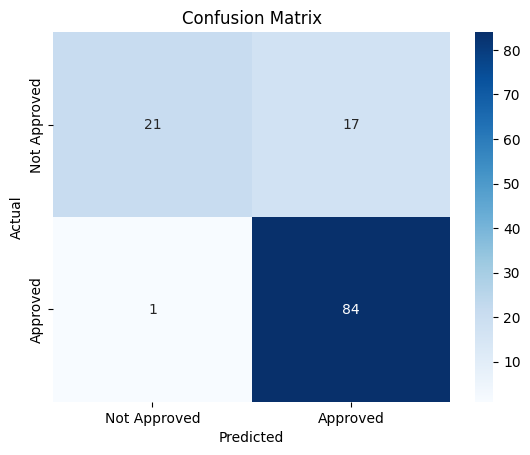

In [46]:
print("\nTest Confusion Matrix:")
cm_lgr = confusion_matrix(y_test, y_test_pred_best_lgr)
sns.heatmap(cm_lgr, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Approved', 'Approved'], 
            yticklabels=['Not Approved', 'Approved'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#### **ROC Curve**

In [47]:
from sklearn.metrics import auc

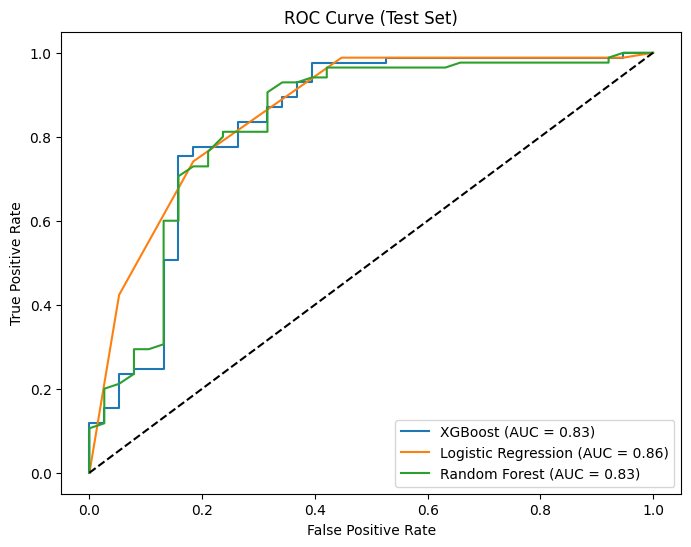

In [48]:
# --- ROC Curve ---
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, best_xgb_y_test_pred_proba)
fpr_lgr, tpr_lgr, _ = roc_curve(y_test, y_test_pred_proba_best_lgr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, best_rf_y_test_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {auc(fpr_xgb, tpr_xgb):.2f})")
plt.plot(fpr_lgr, tpr_lgr, label=f"Logistic Regression (AUC = {auc(fpr_lgr, tpr_lgr):.2f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc(fpr_rf, tpr_rf):.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Test Set)')
plt.legend()
plt.show()

#### **Precision-Recall Curve**

In [49]:
from sklearn.metrics import average_precision_score

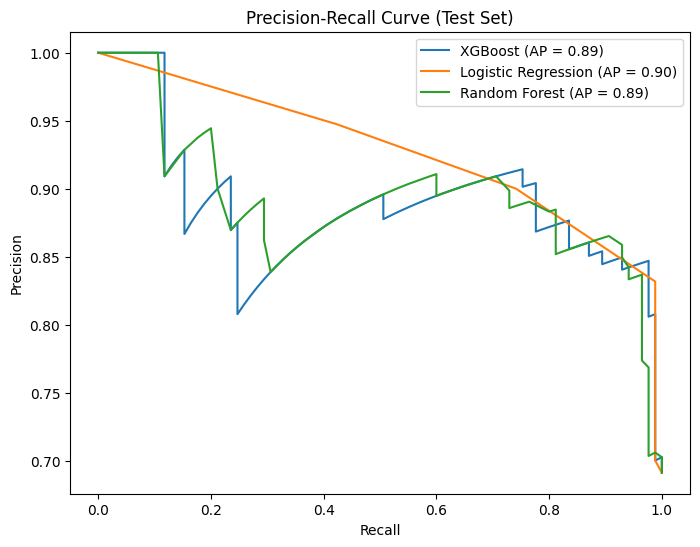

In [50]:
# --- Precision-Recall Curve ---
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, best_xgb_y_test_pred_proba)
precision_lgr, recall_lgr, _ = precision_recall_curve(y_test, y_test_pred_proba_best_lgr)
precision_rf, recall_rf, _ = precision_recall_curve(y_test, best_rf_y_test_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall_xgb, precision_xgb, label=f"XGBoost (AP = {average_precision_score(y_test, best_xgb_y_test_pred_proba):.2f})")
plt.plot(recall_lgr, precision_lgr, label=f"Logistic Regression (AP = {average_precision_score(y_test, y_test_pred_proba_best_lgr):.2f})")
plt.plot(recall_rf, precision_rf, label=f"Random Forest (AP = {average_precision_score(y_test, best_rf_y_test_pred_proba):.2f})")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Test Set)')
plt.legend()
plt.show()

#### **Feature Importance Plot**

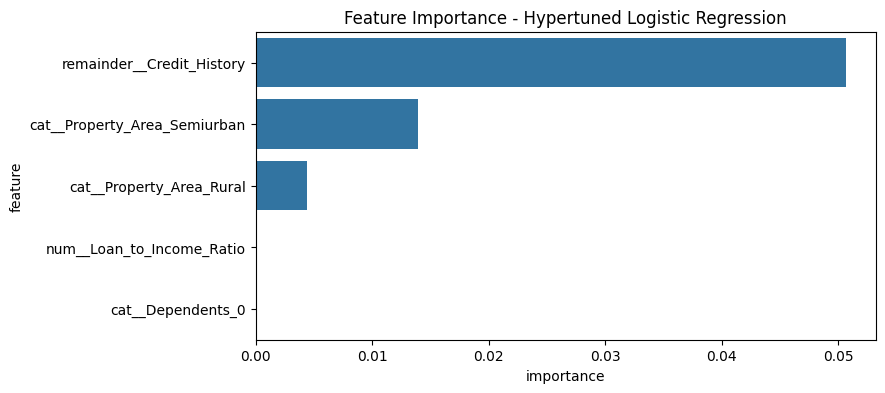

In [51]:
# --- Feature Importance (Hypertuned Logistic Regression) ---
if hasattr(best_lgr_model, 'coef_'):
    importances = [abs(c) for c in best_lgr_model.coef_.reshape(-1)]
    feature_names = X_train_processed_df.columns
    feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

    plt.figure(figsize=(8, 4))
    sns.barplot(x='importance', y='feature', data=feature_importance_df.head(5)) # Show top 5
    plt.title('Feature Importance - Hypertuned Logistic Regression')
    plt.show()

## 9. Conclusion

The primary objective of this project was to develop a robust and accurate model to predict loan approvals. The final model selected for this task is a hyperparameter-tuned Logistic Regression model, which proved to be the most effective solution.

The project journey provided several key insights:

- **Process is Paramount:** By correcting the workflow to split the data **before** any imputation or feature engineering, I ensured that the model's evaluation was free of data leakage. This rigorous approach is fundamental to building a reliable model.

- **Simplicity Can Outperform Complexity:** My initial hypothesis that complex models like Random Forest and XGBoost would perform best was disproven. These models, even after extensive tuning, suffered from significant overfitting. In contrast, the simpler Logistic Regression model demonstrated superior generalization from the start.

- **Optimization is Key:** While the untuned Logistic Regression model was already the best performer, hyperparameter tuning elevated its performance significantly, boosting the test F1-Score to **0.9032**. This demonstrated that even a simple model can be optimized to achieve truly exceptional results.

In conclusion, the chosen Logistic Regression model not only successfully addresses the problem of imbalanced data but also provides a powerful lesson: the best model is not necessarily the most complex one, but the one with the optimal balance of simplicity and performance.

## 10. Model Saving

In [52]:
# 1. Define the directory
import os

base_dir = 'saved_models'
sub_dir = 'loan_approval_prediction_models'
full_path = os.path.join(base_dir, sub_dir)

# 2. Create the directory if it doesn't exist
if not os.path.exists(full_path):
    os.makedirs(full_path)
    print(f"Created directory: '{full_path}'")
else:
    print(f"Directory '{full_path}' already exists.")

# 3. Define the full path for your model file and pipeline
model_filename = os.path.join(full_path, 'Loan_Approval_Predictions_Model.joblib')
preprocessor_filename = os.path.join(full_path, 'StandardScaler_OneHotEncoder_pipeline.joblib')

# 4. Save the model and preprocessor
try:
    joblib.dump(best_lgr_model, model_filename)
    joblib.dump(preprocessor, preprocessor_filename)
    print(f"\nModel and preprocessor successfully saved to: '{full_path}'")
except Exception as e:
    print(f"Error saving files: {e}")

Directory 'saved_models\loan_approval_prediction_models' already exists.

Model and preprocessor successfully saved to: 'saved_models\loan_approval_prediction_models'


In [53]:
# --- How to load the model later ---
# loaded_pipeline = joblib.load(preprocessor_filename)
# loaded_model = joblib.load(model_filename)
# print("Model loaded successfully!")
# You can then use Loaded_pipeline and loaded_model
# new_data_processed = loaded_pipeline.transform(new_data)
# predictions = loaded_model.predict(new_data_processed)